# Explore the uncertainity in the resistance of a sample circuit
http://www.electronics-tutorials.ws/resistor/res_5.html

<img src="res4.gif">

For this simple circuit the questions are 
1. what is the end-to-end resistance and its uncertainity?
1. What are the currents I1 and I2 and uncertaianity?

For each we will assume also that the 12V is not perfect. 

We will try and answer these questions for the circuit as designed and also for the cuircuit as built with a few measurments of the resistors and see how that impacts the results. 

The results are:

$R_{eff} = 6\Omega$

$I_T = 1A, I_1 = I_2 = 0.5A$



In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd

sns.set()
%matplotlib inline

## Components
Each component is assumed to be a normal distriubution of exptected value as listed and the 4, 6, 8 Ohm resistors are 1% while the 12 Ohm is a 5% resistor. 

Per http://docs.pymc.io/api/bounds.html we will use bounded variables because resistances that are negative are nonsensical. 

In [48]:
# setup the model 

# these are the values and precision of each
Datasheets = {'R1':(6.0, 0.01), 
              'R2':(8.0, 0.01),
              'R3':(4.0, 0.01),
              'R4':(12.0, 0.05),
              'V1':(6.0, 0.05),} # 5% on the 12V power supply


with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    # http://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Normal
    # in Bayes world these are considered prior distributions, they are based on previous information
    #   that is gained in some other manner, from the datasheet in this case. 
    R1 = BoundedNormal('R1', mu=Datasheets['R1'][0], sd=Datasheets['R1'][0]*Datasheets['R1'][1])
    R2 = BoundedNormal('R2', mu=Datasheets['R2'][0], sd=Datasheets['R2'][0]*Datasheets['R2'][1])
    R3 = BoundedNormal('R3', mu=Datasheets['R3'][0], sd=Datasheets['R3'][0]*Datasheets['R3'][1])
    R4 = BoundedNormal('R4', mu=Datasheets['R4'][0], sd=Datasheets['R4'][0]*Datasheets['R4'][1])
    # don't bound the voltage as negative is possilbe
    V1 = pm.Normal('V1', mu=Datasheets['V1'][0], sd=Datasheets['V1'][0]*Datasheets['V1'][1])
    
    # Match should all be done on paper first to get the full answer, but we will do steps here because one can.
    #   all at once would be much faster.
    
    # just add them, we will not get info on R2_3 at the output unless we wrap them in pm.Deterministic
    R2_3 = R2+R3
    #   R2_3 = pm.Deterministic('R2_3', R2+R3) 
    
    # now get the resistance answer, and we want details
    R_eff = pm.Deterministic('R_eff', 1/(1/R2_3 + 1/R4))
    
    # total current is then just I=V/R
    I_t = pm.Deterministic('I_t', V1/R_eff)
    # and I_1 and I_2
    I_1 = pm.Deterministic('I_1', I_t*R2_3/R4)
    I_2 = pm.Deterministic('I_2', I_t-I_1)
    
    # makes it all a bit clearner to start in a good place
    start = pm.find_MAP()
    # run a fair number of samples, I have a 8 core machine so run 6
    trace = pm.sample(5000, start=start, njobs=6)

Optimization terminated successfully.
         Current function value: -13.421920
         Iterations: 10
         Function evaluations: 17
         Gradient evaluations: 17


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 210.3:   6%|▌         | 11281/200000 [00:04<01:09, 2708.84it/s] 
Convergence archived at 11300
Interrupted at 11,300 [5%]: Average Loss = 2,904
100%|██████████| 5500/5500 [00:34<00:00, 160.64it/s]


## Explore and explain the results

In the summary what is shown is the variable name ans summary information about each variable. 

We see that:

$R_{eff} = 5.997 \pm 0.3$,  really $R_{eff}$ is between  $[5.705, 6.302]$

or $6\Omega \pm 5\%$

$I_t = 1.001 \pm 0.113$, $[0.892, 1.113]$

or $1.001 \pm 11\%$

So if one is going for a 5% accuracy on the current you cannot say that!


In [49]:

I_t_perc = np.percentile(trace['I_t'], (2.5, 97.5))
I_t_mean = trace['I_t'].mean()
print('I_t = {:.4} +/- {:.4}'.format(I_t_mean, I_t_perc[1]-I_t_mean))
print('I_t = {:.4} +/- {:.4}%'.format(I_t_mean, (I_t_perc[1]-I_t_mean)/I_t_mean*100))

I_t = 1.0 +/- 0.1132
I_t = 1.0 +/- 11.32%


In [50]:
pm.summary(trace, varnames=('R_eff', 'I_t', 'I_1', 'I_2'))


R_eff:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.997            0.152            0.001            [5.711, 6.304]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5.686          5.898          6.001          6.101          6.282


I_t:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.000            0.057            0.001            [0.890, 1.110]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.892          0.961          0.999          1.038          1.114


I_1:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------

We also good visual diagnostics in terms of traceplots. The right side shows the draws, this should always look like hash, the left side is the Kernel Density Esimator of the output distribution. For this problem it should look pretty darn Normal. 

For both summary and traceplot, leavre off varnames to jst get them all...

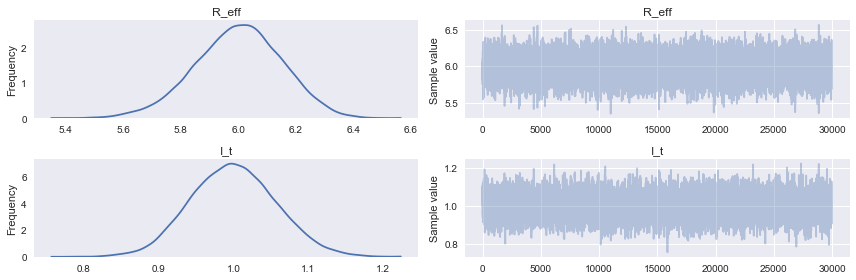

In [51]:
pm.traceplot(trace, combined=True, varnames=('R_eff', 'I_t'));

# Now lets say that we made some measurments of R1 and we can use those to contrain things

The model has to be a bit different to allow for the measurements. Also we will drop the bounded as while true it is kind of annoying to deal with, cannot observe things on a bounded distribution. 

In [52]:
# setup the model 

# these are the values and precision of each
Datasheets = {'R1':(6.0, 0.01), 
              'R2':(8.0, 0.01),
              'R3':(4.0, 0.01),
              'R4':(12.0, 0.05),
              'V1':(6.0, 0.05),} # 5% on the 12V power supply

measuremnts_R1 = [5.987, 5.987] # we measured it twice

with pm.Model() as model:
    # http://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Normal
    # in Bayes world these are considered prior distributions, they are based on previous information
    #   that is gained in some other manner, from the datasheet in this case. 
    #    R1 = pm.Normal('R1', mu=Datasheets['R1'][0], sd=Datasheets['R1'][0]*Datasheets['R1'][1])
    R2 = pm.Normal('R2', mu=Datasheets['R2'][0], sd=Datasheets['R2'][0]*Datasheets['R2'][1])
    R3 = pm.Normal('R3', mu=Datasheets['R3'][0], sd=Datasheets['R3'][0]*Datasheets['R3'][1])
    R4 = pm.Normal('R4', mu=Datasheets['R4'][0], sd=Datasheets['R4'][0]*Datasheets['R4'][1])
    # don't bound the voltage as negative is possilbe
    V1 = pm.Normal('V1', mu=Datasheets['V1'][0], sd=Datasheets['V1'][0]*Datasheets['V1'][1])

    # so on R1 we took some measurments and so have to build it a bit differently
    # use the datasheet for prior
    R1_mean = pm.Normal('R1_mean', mu=Datasheets['R1'][0], sd=Datasheets['R1'][0]*Datasheets['R1'][1])
    R1 = pm.Normal('R1', mu=R1_mean, sd=Datasheets['R1'][0]*Datasheets['R1'][1], observed=measuremnts_R1)
    
    
    # Match should all be done on paper first to get the full answer, but we will do steps here because one can.
    #   all at once would be much faster.
    
    # just add them, we will not get info on R2_3 at the output unless we wrap them in pm.Deterministic
    R2_3 = R2+R3
    #   R2_3 = pm.Deterministic('R2_3', R2+R3) 
    
    # now get the resistance answer, and we want details
    R_eff = pm.Deterministic('R_eff', 1/(1/R2_3 + 1/R4))
    
    # total current is then just I=V/R
    I_t = pm.Deterministic('I_t', V1/R_eff)
    # and I_1 and I_2
    I_1 = pm.Deterministic('I_1', I_t*R2_3/R4)
    I_2 = pm.Deterministic('I_2', I_t-I_1)
    
    # makes it all a bit clearner to start in a good place
    start = pm.find_MAP()
    # run a fair number of samples, I have a 8 core machine so run 6
    trace = pm.sample(5000, start=start, njobs=6)

Optimization terminated successfully.
         Current function value: -9.451417
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.2557:   5%|▌         | 10283/200000 [00:03<01:10, 2682.81it/s]
Convergence archived at 10400
Interrupted at 10,400 [5%]: Average Loss = 98.946
100%|██████████| 5500/5500 [00:17<00:00, 317.19it/s]


In [53]:
pm.summary(trace, varnames=('R_eff', 'I_t', 'I_1', 'I_2'))


R_eff:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.997            0.154            0.001            [5.690, 6.290]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5.685          5.895          6.001          6.103          6.287


I_t:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.001            0.056            0.000            [0.892, 1.112]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.893          0.962          0.999          1.038          1.114


I_1:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------

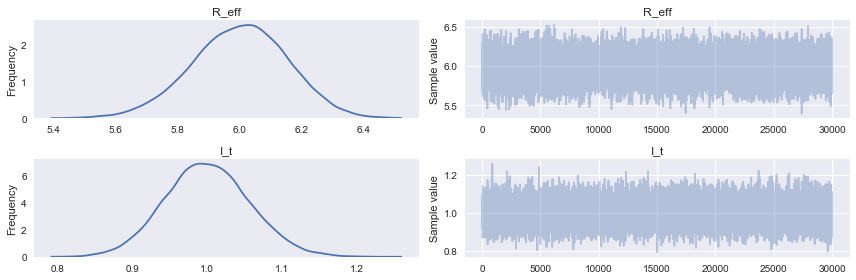

In [54]:
pm.traceplot(trace, combined=True, varnames=('R_eff', 'I_t'));

## Results 
So while not a huge difference a single measurment of R1 changed the results:

$R_{eff} = [5.705, 6.302]$ became $R_{eff} = [5.688, 6.282]$

$I_t = [0.892, 1.113]$ became $I_t = [0.891, 1.110]$

A not huge difference but a shift down. 



In [55]:
I_t_perc = np.percentile(trace['I_t'], (2.5, 97.5))
I_t_mean = trace['I_t'].mean()
print('I_t = {:.4} +/- {:.4}'.format(I_t_mean, I_t_perc[1]-I_t_mean))
print('I_t = {:.4} +/- {:.4}%'.format(I_t_mean, (I_t_perc[1]-I_t_mean)/I_t_mean*100))

I_t = 1.001 +/- 0.1134
I_t = 1.001 +/- 11.33%


# How about we buy a better R4?
Buy a 1% not a 5%

rerun first model with the better resistor (different Bayesian Prior)

In [56]:
# setup the model 

# these are the values and precision of each
Datasheets = {'R1':(6.0, 0.01), 
              'R2':(8.0, 0.01),
              'R3':(4.0, 0.01),
              'R4':(12.0, 0.01), # better resistor
              'V1':(6.0, 0.05),} # 5% on the 12V power supply


with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    # http://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Normal
    # in Bayes world these are considered prior distributions, they are based on previous information
    #   that is gained in some other manner, from the datasheet in this case. 
    R1 = BoundedNormal('R1', mu=Datasheets['R1'][0], sd=Datasheets['R1'][0]*Datasheets['R1'][1])
    R2 = BoundedNormal('R2', mu=Datasheets['R2'][0], sd=Datasheets['R2'][0]*Datasheets['R2'][1])
    R3 = BoundedNormal('R3', mu=Datasheets['R3'][0], sd=Datasheets['R3'][0]*Datasheets['R3'][1])
    R4 = BoundedNormal('R4', mu=Datasheets['R4'][0], sd=Datasheets['R4'][0]*Datasheets['R4'][1])
    # don't bound the voltage as negative is possilbe
    V1 = pm.Normal('V1', mu=Datasheets['V1'][0], sd=Datasheets['V1'][0]*Datasheets['V1'][1])
    
    # Match should all be done on paper first to get the full answer, but we will do steps here because one can.
    #   all at once would be much faster.
    
    # just add them, we will not get info on R2_3 at the output unless we wrap them in pm.Deterministic
    R2_3 = R2+R3
    #   R2_3 = pm.Deterministic('R2_3', R2+R3) 
    
    # now get the resistance answer, and we want details
    R_eff = pm.Deterministic('R_eff', 1/(1/R2_3 + 1/R4))
    
    # total current is then just I=V/R
    I_t = pm.Deterministic('I_t', V1/R_eff)
    # and I_1 and I_2
    I_1 = pm.Deterministic('I_1', I_t*R2_3/R4)
    I_2 = pm.Deterministic('I_2', I_t-I_1)
    
    # makes it all a bit clearner to start in a good place
    start = pm.find_MAP()
    # run a fair number of samples, I have a 8 core machine so run 6
    trace = pm.sample(5000, start=start, njobs=6)

Optimization terminated successfully.
         Current function value: -15.030161
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 277.01:   6%|▌         | 11131/200000 [00:04<01:11, 2634.68it/s]
Convergence archived at 11300
Interrupted at 11,300 [5%]: Average Loss = 3,782.6
100%|██████████| 5500/5500 [00:22<00:00, 248.31it/s]


In [57]:

I_t_perc = np.percentile(trace['I_t'], (2.5, 97.5))
I_t_mean = trace['I_t'].mean()
print('I_t = {:.4} +/- {:.4}'.format(I_t_mean, I_t_perc[1]-I_t_mean))
print('I_t = {:.4} +/- {:.4}%'.format(I_t_mean, (I_t_perc[1]-I_t_mean)/I_t_mean*100))

I_t = 0.9998 +/- 0.09849
I_t = 0.9998 +/- 9.852%


The better resistor helped but are are dominated somewhere else... power supply!